In [1]:
import os
from pathlib import Path
from typing import Callable
import warnings

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from segregation.aspatial import Dissim, MinMax
import rasterio as rio
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

data_dir = Path('../data')
YEARS = [1880, 1888, 1895, 1900, 1902, 1913, 1915]
BWS = 100, 150, 200, 250, 300, 400, 500
CELL_SIZE = 10

/home/antth/anaconda3/envs/spatial_segregation/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def get_xy(
        geodf: gpd.GeoDataFrame,
        geometry_col: str = None,
) -> gpd.GeoDataFrame:

    if not geometry_col:
        geometry_col = geodf.geometry.name

    if geodf[geometry_col].geom_type[0] == 'Point':
        geodf['x'] = geodf[geometry_col].apply(lambda geom: geom.x)
        geodf['y'] = geodf[geometry_col].apply(lambda geom: geom.y)
    else:
        geodf['x'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[0]))
        geodf['y'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[1]))
    return geodf


def kernel_density_surface(
        data: gpd.GeoDataFrame,
        group: str,
        bandwidth,
        cell_size,
        kernel_function: Callable,
):
    pop = get_xy(data)
    pad = 0

    minx, miny, maxx, maxy = pop.geometry.total_bounds

    minx -= pad
    miny -= pad
    maxx += pad
    maxy += pad

    x = np.arange(minx, maxx, cell_size)
    y = np.arange(miny, maxy, cell_size)

    X, Y = np.meshgrid(x, y)

    xy = np.vstack([Y.ravel(), X.ravel()]).T

    U = cdist(xy, pop[['y', 'x']].values, metric='euclidean')
    W = kernel_function(U, bandwidth=bandwidth)

    density = (W * pop[group].values).sum(axis=1).reshape(X.shape)

    geotiff_meta = {
        'driver': 'GTiff',
        'count': 1,
        'dtype': density.dtype,
        'width': density.shape[1],
        'height': density.shape[0],
        'crs': data.crs,
        'transform': rio.transform.from_bounds(
            west=minx,
            east=maxx,
            north=maxy,
            south=miny,
            width=len(x),
            height=len(y),
        )
    }

    return density[::-1, ], geotiff_meta


def get_S(
        data,
        bandwidth,
        cell_size,
        kernel_function,
):
    if data.empty:
        return None

    density_total, _ = kernel_density_surface(
        data,
        group='total',
        bandwidth=bandwidth,
        cell_size=cell_size,
        kernel_function=kernel_function,
    )
    density_orthodox, _ = kernel_density_surface(
        data,
        group='orthodox',
        bandwidth=bandwidth,
        cell_size=cell_size,
        kernel_function=kernel_function,
    )

    density = pd.DataFrame({
            'orthodox': density_orthodox.flatten(),
            'total': density_total.flatten(),
         })
    S = MinMax(density, 'orthodox', 'total')

    return S


In [3]:

def remove_institutions(
        pop_data: pd.DataFrame,
        institutions: pd.DataFrame,
        year,
):
    institutions = institutions.set_index(['district', 'plot_number'])
    institutions = institutions.loc[institutions.year == year]

    for idx in institutions.index:
        pop_data = pop_data.drop(index=idx, errors='ignore')

    return pop_data


def handle_combined_plots(
        pop_data: pd.DataFrame,
        target_column: str = 'plot_number',
):
    target_shape = pop_data.shape
    index_columns = pop_data.index.names
    pop_data.reset_index(inplace=True)
    pop_data[target_column] = [e.split(',')[0].strip() for e in pop_data[target_column]]
    pop_data.set_index(index_columns, inplace=True)

    assert pop_data.shape == target_shape

    return pop_data


def prepare_pop_data(
        population_data: pd.DataFrame,
        num_cols=None,
) -> pd.DataFrame:

    pop_frame = population_data.fillna(value=0)

    if not num_cols:
        num_cols = [
            'total_men',
            'total_women',
            'orthodox',
            'other_christian',
            'other_religion',
        ]

    pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)

    pop_frame['lutheran'] = pop_frame['total_men total_women'.split()].sum(axis=1) \
                            - pop_frame['other_christian orthodox other_religion'.split()].sum(axis=1)

    pop_frame['total'] = pop_frame['other_christian orthodox other_religion lutheran'.split()].sum(axis=1)

    return pop_frame


In [4]:
def split_plots(
        geodataframe: gpd.GeoDataFrame,
        target_col: str,
        separator: str = ',',
) -> gpd.GeoDataFrame:

    new_geodataframe = gpd.GeoDataFrame(columns=geodataframe.columns)

    for _, row in geodataframe.iterrows():
        plots = str(row[target_col]).split(separator)

        if len(plots) < 2:
            new_geodataframe = new_geodataframe.append(row)
            continue

        for plot in plots:
            new_row = row
            new_row[target_col] = plot
            new_geodataframe = new_geodataframe.append(new_row)

    assert len(new_geodataframe.index) == len(list(pd.core.common.flatten(
        [
            str(w).split(separator)
            for w
            in geodataframe[target_col]
        ]))), 'splitting failed'

    return new_geodataframe.reindex()


In [5]:
def quartic_kernel(u, bandwidth):
    return np.where(
            np.abs(u) <= bandwidth,
            3 / (np.pi * bandwidth * bandwidth) * (1 - (u / bandwidth) ** 2) ** 2,
            0
    )

In [6]:
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

location_data = gpd.read_file(data_dir / 'raw' / 'plots_1878.gpkg').to_crs(epsg=3067)
location_data = split_plots(location_data, target_col='NUMBER')
location_data['district'] = [district_codes[int(d)] for d in location_data['DISTRICT']]
location_data['plot_number'] = [str(i) for i in location_data['NUMBER']]
location_data = location_data.set_index(['district', 'plot_number'])
city = gpd.read_file(data_dir / 'raw' / 'city_1846.shp').to_crs(epsg=3067)
location_data = location_data.loc[~location_data.geometry.within(city.geometry[0]).index.duplicated()]
location_data = location_data.loc[location_data.geometry.within(city.geometry[0])]

/tmp/ipykernel_56190/4003846893.py:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)
/tmp/ipykernel_56190/4003846893.py:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)
/tmp/ipykernel_56190/4003846893.py:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]

           100       150       200       250       300       400       500
1880  0.567445  0.499488  0.446074  0.405734  0.374279  0.328171  0.286454
1888  0.525910  0.452875  0.403864  0.370109  0.346133  0.308815  0.274802
1895  0.537273  0.473650  0.427550  0.389220  0.358308  0.312816  0.274951
1900  0.530197  0.441736  0.392662  0.362604  0.341207  0.306511  0.277726
1902  0.521096  0.441375  0.394936  0.371054  0.358726  0.338301  0.319397
1913  0.573523  0.498742  0.455438  0.423047  0.397554  0.362419  0.339007
1915  0.583133  0.523483  0.493636  0.468684  0.444803  0.404947  0.382474


<AxesSubplot: >

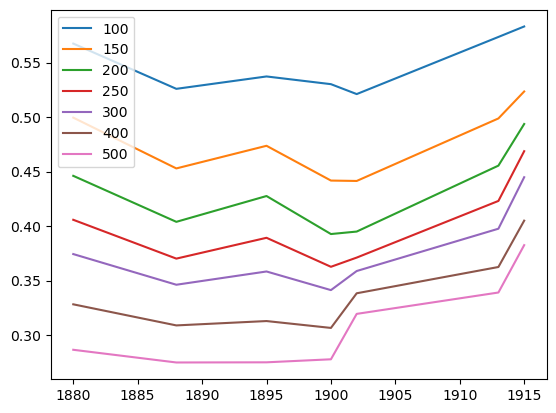

In [7]:
results = {}

for year in YEARS:
    s_ = []

    for bw in BWS:
        population_data = pd.read_csv(
            data_dir / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)
        population_data.rename({'representative_plot': 'plot_number'}, axis=1, inplace=True)
        population_data = population_data.set_index(['district', 'plot_number'], drop=True)

        population_data = population_data.pipe(handle_combined_plots).pipe(remove_institutions, institutions, year)

        page_location_data = location_data.join(population_data, on=['district', 'plot_number'])
        page_location_data.dropna(axis=0, inplace=True)

        for group in 'orthodox', 'lutheran', 'total':
            file = data_dir / 'processed' / f"{group}_density_{year}_{bw}_m.tif"
            if file.exists():
                continue
            
            density, raster_args = kernel_density_surface(
                page_location_data,
                group=group,
                bandwidth=bw,
                cell_size=CELL_SIZE,
                kernel_function=quartic_kernel,
            )
            density = density * 10_000

            with rio.open(file, 'w', **raster_args) as rfile:
                rfile.write(density, 1)

        S = get_S(
            data=page_location_data,
            bandwidth=bw,
            cell_size=CELL_SIZE,
            kernel_function=quartic_kernel,
        )

        s_.append(S.statistic)

    results[year] = s_

results = pd.DataFrame.from_dict(
    results,
    orient='index',
    columns=BWS,
)
print(results)
results.plot()

/tmp/ipykernel_56190/4003846893.py:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)
/tmp/ipykernel_56190/4003846893.py:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)
/tmp/ipykernel_56190/4003846893.py:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]

           100       150       200       250       300       400       500  \
1880  0.567445  0.499488  0.446074  0.405734  0.374279  0.328171  0.286454   
1888  0.525910  0.452875  0.403864  0.370109  0.346133  0.308815  0.274802   
1895  0.537273  0.473650  0.427550  0.389220  0.358308  0.312816  0.274951   
1900  0.530197  0.441736  0.392662  0.362604  0.341207  0.306511  0.277726   
1902  0.521096  0.441375  0.394936  0.371054  0.358726  0.338301  0.319397   
1913  0.573523  0.498742  0.455438  0.423047  0.397554  0.362419  0.339007   
1915  0.583133  0.523483  0.493636  0.468684  0.444803  0.404947  0.382474   

             D  
1880  0.108398  
1888  0.084223  
1895  0.113486  
1900  0.092362  
1902  0.102609  
1913  0.131011  
1915  0.141271  


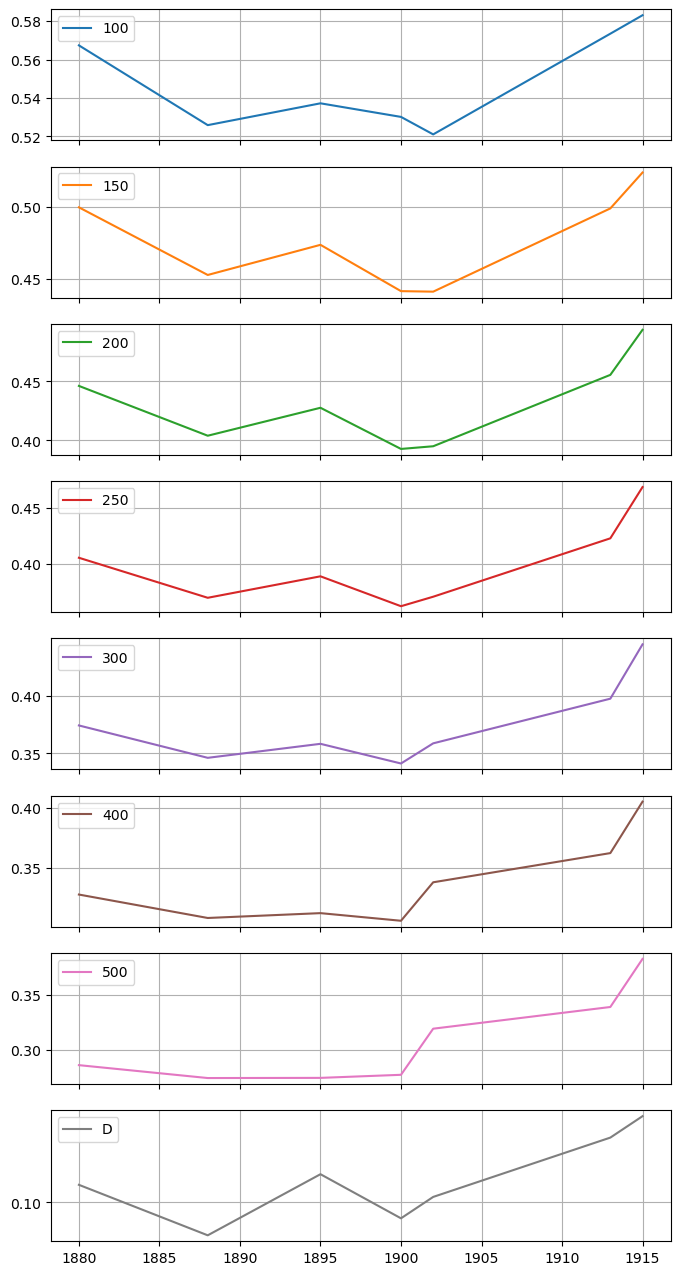

In [9]:
districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

results_D = {}

for year in YEARS:
    population_data = pd.read_csv(
            data_dir / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)
    population_data = population_data[population_data.district.isin(districts_in_city)]
    population_data = population_data.loc[:, ['district', 'lutheran', 'orthodox', 'total']].groupby('district').sum()
    totals = pd.Series(population_data.sum(axis=0), name='totals')
    population_data = population_data.append(totals)

    D = Dissim(
        population_data,
        group_pop_var='orthodox',
        total_pop_var='total',
    )
    results_D[year] = D.statistic

    # print(f'    {year}:')
    # print(population_data)
    # print()

results['D'] = pd.Series(results_D)
print(results)
fig, *axes = results.plot(
    figsize=(8, 16),
    subplots=True,
    grid=True,
)
for ax in axes:
    ticks = np.arange(0, 1, 0.05)
    ax.set_yticks(ticks)
    ax.autoscale_view()
plt.savefig('../figures/S_and_D.png')